In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from utils.blockJpeg import get_quantification_matrix
import glob
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import utils.makeDataset as DatasetMaker
from utils.training import unique_images, get_average_dct
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix

# Create Datasets

In [10]:
# D19, D20 : 75 , 75+100
# D21, D22 : 100, 100+100
DATA_FOLDER = '../data'
OUTPUT_DATA_FOLDER= "../output/datasets"
OUTPUT_IMG_FOLDER = "../output/CompressedImg"
DATASETS = [25, 26] # datasets to train and test
q1 = 75 # first quantification
q2 = 90 # second quantification

block = 8
BL_COMPUTE_AVG = True # Image represented by its average DCT

In [3]:
def showImage(img):
    plt.figure(figsize=(15,15))
    plt.imshow(img,cmap='gray')
    plt.xticks([]),plt.yticks([])
    plt.show()

def slice_image(image):
    height, width = image.shape
    sliced = [] # new list for 8x8 sliced image
    #dividing 8x8 parts
    currY = 0 #current Y index
    for i in range(block,height+1,block):
        currX = 0 #current X index
        for j in range(block,width+1,block):
            sliced.append(image[currY:i,currX:j])
            currX = j
        currY = i
    return sliced

def compute_dct(sliced_img):
    dct_output = [cv2.dct(part) for part in sliced_img]
    return dct_output


def quantification(dct_output, selected_qmatrix, around=np.around):
    quantification_output = []
    for block_dct in dct_output:
        quantification_output.append(around(block_dct/selected_qmatrix))
    return quantification_output

def inverse_quantification(quantiOutput, selected_qmatrix, around=np.around):
    inverse_quantiOutput = []
    for block_dct in quantiOutput:
        inverse_quantiOutput.append(around(block_dct*selected_qmatrix))
    return inverse_quantiOutput

def compute_idct(inverse_quantiOutput):
    invList = [cv2.idct(ipart) for ipart in inverse_quantiOutput]
    return invList

def unslice_image(idct_output, img_width):
    row = 0
    rowNcol = []
    for j in range(int(img_width/block),len(idct_output)+1,int(img_width/block)):
        rowNcol.append(np.hstack((idct_output[row:j])))
        row = j
    res = np.vstack((rowNcol))
    return res


def get_dataset_number():
    return len(glob.glob(os.path.join(OUTPUT_DATA_FOLDER, '*'))) + 1

In [4]:
def create_dataset(output_data_folder, input_data_folder, q, nb_img, output_img_folder=False):

    if not os.path.exists(output_data_folder):
        os.mkdir(output_data_folder)

    dataset_number = get_dataset_number()
    # Place pictures with same compression settings in a common folder
    dataset_output = os.path.join(output_data_folder, str(dataset_number))
    if not os.path.exists(dataset_output):
        os.mkdir(dataset_output)

    pictures = os.listdir(input_data_folder)

    if nb_img>len(pictures):
        raise Exception('nb_img is higher than the total number of images in the input_data_folder')
    else:
        for pic_ind in tqdm(range(nb_img)):
            pic_name = pictures[pic_ind]

            img = cv2.imread(input_data_folder + '/'+ pic_name, 0)
            img = np.float32(img) - 128
            sliced = slice_image(img)
            DCToutput = compute_dct(sliced)
            quantiOutput = quantification(DCToutput, get_quantification_matrix(q), np.around)

            np.save(dataset_output + "/" + pic_name + ".npy", DCToutput)
            # get result here for classification

            if output_img_folder :
                ## Inverse quantification
                if not os.path.exists(output_img_folder):
                    os.mkdir(output_img_folder)

                inverse_quantiOutput = inverse_quantification(quantiOutput, get_quantification_matrix(q), np.around)
                idct_output = compute_idct(inverse_quantiOutput)
                res = unslice_image(idct_output, img.shape[1])
                plt.imsave(output_img_folder+'/'+pic_name+'.png', res, format='png', cmap='gray')

In [8]:
# Datasets 19 - 20 (75 - 75+100)
# create_dataset(OUTPUT_DATA_FOLDER, DATA_FOLDER, q1, 200, OUTPUT_IMG_FOLDER+'/'+str(q1))
# create_dataset(OUTPUT_DATA_FOLDER, OUTPUT_IMG_FOLDER+'/'+str(q1), q2, 200, OUTPUT_IMG_FOLDER+'/'+str(q1)+'_'+str(q2))

100%|██████████| 200/200 [00:32<00:00,  6.09it/s]


In [13]:
# Datasets 21 - 22 (100 - 100+100)
# create_dataset(OUTPUT_DATA_FOLDER, DATA_FOLDER, q2, 200, OUTPUT_IMG_FOLDER+'/'+str(q2))
# create_dataset(OUTPUT_DATA_FOLDER, OUTPUT_IMG_FOLDER+'/'+str(q2), q2, 200, OUTPUT_IMG_FOLDER+'/'+str(q2)+'_'+str(q2))


# Train the model

score 0.75


c:\users\shiti\documents\m2\uv2_projet\projet_py\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


cross validation score : 0.68


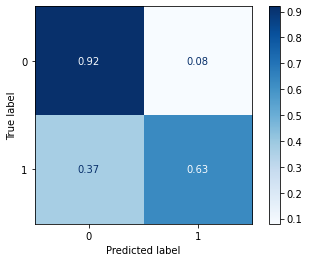

In [11]:
# New dataset without duplicated image
X = []
y_labels = []

for current_dataset in DATASETS:
    _, X_current = DatasetMaker.load_dataset(current_dataset)
    y_labels += [current_dataset] * len(X_current)
    if BL_COMPUTE_AVG:
        X += get_average_dct(X_current)
    else:
        X += X_current

le = preprocessing.LabelEncoder()
y = le.fit_transform(y_labels)

new_X, new_y = unique_images(X, y.tolist())


# Train test split
rfc = RandomForestClassifier(max_depth=10, criterion='entropy')
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.3, random_state=123)
rfc.fit(X_train, y_train)
print("score", rfc.score(X_test, y_test))
plot_confusion_matrix(rfc, X_test, y_test, normalize='true', cmap=plt.cm.Blues)


# Cross validation
rfc = RandomForestClassifier(max_depth=10, criterion='entropy')
print('cross validation score :', np.mean(cross_val_score(rfc, new_X, new_y, cv=5)))
